In [1]:
# Basic libraries
import torch
import torch.nn as n
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from typing import List
import torch.optim as optim
from tqdm import tqdm
from omegaconf import OmegaConf

In [2]:
os.chdir("../")
# Personalized modules
from preprocess.dataloader import AntibodiesTree
from preprocess.patches_utils import PatchesUtilities

from osgen.embeddings import StyleExtractor
from osgen.utils import Utilities
from osgen.vae import VanillaVAE,VanillaEncoder, VanillaDecoder
from osgen.base import BaseModel
from osgen.nn import *
from osgen.unet import *
from osgen.loss import *
from osgen.pipeline import *

In [3]:
# Load config
cfg = OmegaConf.load("/root/BiOSGen/configs/train_config.yml")
print(cfg.verbose)

True


In [4]:
# SRC antibodies
tree_src = AntibodiesTree(
    image_dir = "/root/BiOSGen/data/HE",
    mask_dir = "/root/BiOSGen/data/tissue_masks/HE",
    npz_dir = "/root/BiOSGen/data/bbox_info/HE_NKX3/HE"
)

# DST antibodies
tree_dst = AntibodiesTree(
    image_dir = "/root/BiOSGen/data/NKX3",
    mask_dir = "/root/BiOSGen/data/tissue_masks/NKX3",
    npz_dir = "/root/BiOSGen/data/bbox_info/HE_NKX3/NKX3"
)

# Print
print("Nb antibodies: ", tree_src.get_nb_antibodies())
print("Nb antibodies: ", tree_dst.get_nb_antibodies())

Nb antibodies:  248
Nb antibodies:  248


In [5]:
idx_src = 20 # torch.randint(0, len(tree_src.antibodies), (1,)).item()
patches_src = PatchesUtilities.get_image_patches(
    image = np.array(Image.open(tree_src.antibodies[idx_src])),
    tissue_mask = PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_src.antibodies[idx_src]))),
)

idx_dst = 60 # torch.randint(0, len(tree_dst.antibodies), (1,)).item()
patches_dst = PatchesUtilities.get_image_patches(
    image = np.array(Image.open(tree_dst.antibodies[idx_dst])),
    tissue_mask = PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_dst.antibodies[idx_dst]))),
)
print("idx_src: ", idx_src)
print("idx_dst: ", idx_dst)

idx_src:  20
idx_dst:  60


In [6]:
# Initialize your pipeline
pipeline = OSGenPipeline()

# Load the checkpoint file (a state_dict)
checkpoints = torch.load("/root/BiOSGen/checkpoints/main/pipeline_full_best_100_epoch_512.pth")


/tmp/ipykernel_36122/3007567791.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoints = torch.load("/root/BiOSGen/checkpoints/main/pipeline_full_best_100_epoch_512

In [7]:
checkpoint_keys = set(checkpoints['model_state_dict'].keys())
pipeline_keys = set(pipeline.state_dict().keys())

print("Keys only in checkpoint:", checkpoint_keys - pipeline_keys)
print("Keys only in pipeline:", pipeline_keys - checkpoint_keys)
print("Common keys:", checkpoint_keys & pipeline_keys)

# Check for shape mismatches in common keys
print("\nShape mismatches:")
for key in checkpoint_keys & pipeline_keys:
    if checkpoints['model_state_dict'][key].shape != pipeline.state_dict()[key].shape:
        print(f"{key}: checkpoint shape = {checkpoints['model_state_dict'][key].shape}, pipeline shape = {pipeline.state_dict()[key].shape}")

Keys only in checkpoint: {'unet.input_blocks.5.0.post_adain.channel_reducer.weight', 'unet.output_blocks.4.0.pre_adain.channel_reducer.bias', 'unet.input_blocks.11.0.pre_adain.channel_reducer.weight', 'unet.input_blocks.10.0.pre_adain.channel_reducer.bias', 'unet.output_blocks.4.0.post_adain.channel_reducer.weight', 'unet.input_blocks.8.0.pre_adain.channel_reducer.bias', 'unet.middle_block.0.post_adain.channel_reducer.weight', 'unet.output_blocks.5.0.pre_adain.channel_reducer.bias', 'unet.output_blocks.7.0.post_adain.channel_reducer.bias', 'decoder.final_layer.1.running_mean', 'style_extractor.conv_style.1.running_var', 'unet.middle_block.0.post_adain.channel_reducer.bias', 'encoder.encoder.1.1.num_batches_tracked', 'unet.output_blocks.10.0.pre_adain.channel_reducer.weight', 'decoder.encoder.1.1.running_mean', 'unet.output_blocks.1.0.pre_adain.channel_reducer.bias', 'unet.input_blocks.5.0.pre_adain.channel_reducer.bias', 'style_extractor.conv_style.4.running_var', 'unet.output_blocks.8

In [8]:
# Hyperparameters
verbose = cfg.verbose
num_epochs = 10
batch_size = cfg.batch_size
lr = cfg.lr
optimizer = optim.AdamW([p for p in pipeline.parameters() if p.requires_grad], 
                        lr=cfg.optimizer.params.lr, weight_decay=cfg.optimizer.params.weight_decay, eps=cfg.optimizer.params.eps)

channels = cfg.channels
height = cfg.height
width = cfg.width
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lambda_content = cfg.lambda_content
lambda_style = cfg.lambda_style

# Training loop
# Put on training mode
pipeline.train()
requires_grad = True

# Early stopping parameters
early_stopping_patience = cfg.early_stopping_patience
epochs_without_improvement = 0
best_loss = float("inf")

# Convergence check parameters
convergence_patience = 5  # Number of epochs to check for convergence
convergence_threshold = 0.001  # Minimum relative change in loss to continue training
loss_history = []  # Keep track of recent losses

# Save losses
losses = []
content_losses = []
style_losses = []

# Switch to main training with bfloat16
for epoch in tqdm(range(num_epochs)):
    # print(f"Epoch {epoch+1}/{num_epochs}")
    avg_loss = []
    content_loss = []
    style_loss = []

    for i, (src, dst) in enumerate(zip(patches_src, patches_dst)):
        # Convert to tensors
        src_tensor = Utilities.convert_numpy_to_tensor(src).to(device)
        dst_tensor = Utilities.convert_numpy_to_tensor(dst).to(device)

        timesteps = torch.randint(0, 1000, (batch_size,), device=device)  # Random timesteps

        # forward pass
        decoded = pipeline(src_tensor, dst_tensor, timesteps)

        # Handle gradients issues
        requires_grad = decoded.requires_grad
        # print(requires_grad)
        if not requires_grad:
            break

        # Compute loss
        content_l, style_l, total_loss = pipeline.compute_loss(src_tensor, dst_tensor, decoded, lambda_content, lambda_style)

        # Break if total_loss is NaN
        if torch.isnan(total_loss):
            print(f"NaN loss at epoch {epoch+1}, batch {i+1}")
            break

        print(f"Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(patches_src)}, "
                f"Content Loss: {content_l.item():.4f}, Style Loss: {style_l.item():.4f}, "
                f"Total Loss: {total_loss.item():.4f}")

        avg_loss.append(total_loss.item())
        content_loss.append(content_l.item())
        style_loss.append(style_l.item())

        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10, Batch 1/95, Content Loss: 86.4648, Style Loss: 162.2173, Total Loss: 248.6821
Epoch 1/10, Batch 2/95, Content Loss: 140.6847, Style Loss: 776.6458, Total Loss: 917.3304
Epoch 1/10, Batch 3/95, Content Loss: 128.2922, Style Loss: 60.3954, Total Loss: 188.6876
Epoch 1/10, Batch 4/95, Content Loss: 52.6883, Style Loss: 36.9385, Total Loss: 89.6268
Epoch 1/10, Batch 5/95, Content Loss: 151.6712, Style Loss: 963.9034, Total Loss: 1115.5746
Epoch 1/10, Batch 6/95, Content Loss: 170.9666, Style Loss: 110.7060, Total Loss: 281.6727
Epoch 1/10, Batch 7/95, Content Loss: 221.2709, Style Loss: 112.4130, Total Loss: 333.6839
Epoch 1/10, Batch 8/95, Content Loss: 176.2838, Style Loss: 62.2883, Total Loss: 238.5721
Epoch 1/10, Batch 9/95, Content Loss: 178.0047, Style Loss: 66.7277, Total Loss: 244.7325
Epoch 1/10, Batch 10/95, Content Loss: 190.2400, Style Loss: 139.6994, Total Loss: 329.9395
Epoch 1/10, Batch 11/95, Content Loss: 158.4086, Style Loss: 75.3512, Total Loss: 233.7598
Epoc

 10%|█         | 1/10 [00:16<02:31, 16.86s/it]

Epoch 1/10, Batch 94/95, Content Loss: 60.6277, Style Loss: 13.2933, Total Loss: 73.9210
Epoch 2/10, Batch 1/95, Content Loss: 32.5888, Style Loss: 14.2921, Total Loss: 46.8809
Epoch 2/10, Batch 2/95, Content Loss: 36.3358, Style Loss: 13.8225, Total Loss: 50.1582
Epoch 2/10, Batch 3/95, Content Loss: 28.3691, Style Loss: 17.3715, Total Loss: 45.7406
Epoch 2/10, Batch 4/95, Content Loss: 15.4401, Style Loss: 12.2377, Total Loss: 27.6778
Epoch 2/10, Batch 5/95, Content Loss: 33.5074, Style Loss: 20.7391, Total Loss: 54.2464
Epoch 2/10, Batch 6/95, Content Loss: 72.2979, Style Loss: 14.5287, Total Loss: 86.8265
Epoch 2/10, Batch 7/95, Content Loss: 85.5445, Style Loss: 12.0350, Total Loss: 97.5795
Epoch 2/10, Batch 8/95, Content Loss: 65.9041, Style Loss: 15.4194, Total Loss: 81.3235
Epoch 2/10, Batch 9/95, Content Loss: 66.7368, Style Loss: 10.4731, Total Loss: 77.2099
Epoch 2/10, Batch 10/95, Content Loss: 75.0551, Style Loss: 17.2762, Total Loss: 92.3313
Epoch 2/10, Batch 11/95, Conte

 20%|██        | 2/10 [00:32<02:07, 15.90s/it]

Epoch 2/10, Batch 94/95, Content Loss: 48.3255, Style Loss: 11.1750, Total Loss: 59.5005
Epoch 3/10, Batch 1/95, Content Loss: 24.3566, Style Loss: 10.1971, Total Loss: 34.5537
Epoch 3/10, Batch 2/95, Content Loss: 30.6892, Style Loss: 9.8573, Total Loss: 40.5465
Epoch 3/10, Batch 3/95, Content Loss: 21.9508, Style Loss: 13.6595, Total Loss: 35.6102
Epoch 3/10, Batch 4/95, Content Loss: 15.9724, Style Loss: 10.7121, Total Loss: 26.6846
Epoch 3/10, Batch 5/95, Content Loss: 28.9748, Style Loss: 11.4650, Total Loss: 40.4397
Epoch 3/10, Batch 6/95, Content Loss: 63.8812, Style Loss: 12.1536, Total Loss: 76.0348
Epoch 3/10, Batch 7/95, Content Loss: 80.8600, Style Loss: 12.0867, Total Loss: 92.9467
Epoch 3/10, Batch 8/95, Content Loss: 62.4975, Style Loss: 14.1201, Total Loss: 76.6176
Epoch 3/10, Batch 9/95, Content Loss: 62.5977, Style Loss: 8.5550, Total Loss: 71.1527
Epoch 3/10, Batch 10/95, Content Loss: 69.6298, Style Loss: 13.7282, Total Loss: 83.3581
Epoch 3/10, Batch 11/95, Content

 30%|███       | 3/10 [00:46<01:46, 15.28s/it]

Epoch 3/10, Batch 94/95, Content Loss: 42.1483, Style Loss: 9.2465, Total Loss: 51.3949
Epoch 4/10, Batch 1/95, Content Loss: 29.7790, Style Loss: 9.4095, Total Loss: 39.1885
Epoch 4/10, Batch 2/95, Content Loss: 28.7917, Style Loss: 7.5550, Total Loss: 36.3467
Epoch 4/10, Batch 3/95, Content Loss: 24.8482, Style Loss: 11.7897, Total Loss: 36.6379
Epoch 4/10, Batch 4/95, Content Loss: 18.3974, Style Loss: 8.4928, Total Loss: 26.8901
Epoch 4/10, Batch 5/95, Content Loss: 24.4441, Style Loss: 9.7865, Total Loss: 34.2306
Epoch 4/10, Batch 6/95, Content Loss: 57.3266, Style Loss: 13.0485, Total Loss: 70.3750
Epoch 4/10, Batch 7/95, Content Loss: 76.5717, Style Loss: 12.6760, Total Loss: 89.2477
Epoch 4/10, Batch 8/95, Content Loss: 59.6441, Style Loss: 15.4951, Total Loss: 75.1392
Epoch 4/10, Batch 9/95, Content Loss: 59.9337, Style Loss: 8.2992, Total Loss: 68.2328
Epoch 4/10, Batch 10/95, Content Loss: 62.7320, Style Loss: 12.0206, Total Loss: 74.7526
Epoch 4/10, Batch 11/95, Content Los

 40%|████      | 4/10 [01:02<01:32, 15.47s/it]

Epoch 4/10, Batch 94/95, Content Loss: 37.5945, Style Loss: 9.3269, Total Loss: 46.9214
Epoch 5/10, Batch 1/95, Content Loss: 28.4972, Style Loss: 9.6134, Total Loss: 38.1105
Epoch 5/10, Batch 2/95, Content Loss: 27.3003, Style Loss: 7.6365, Total Loss: 34.9368
Epoch 5/10, Batch 3/95, Content Loss: 23.1990, Style Loss: 11.0626, Total Loss: 34.2616
Epoch 5/10, Batch 4/95, Content Loss: 18.7646, Style Loss: 8.1660, Total Loss: 26.9306
Epoch 5/10, Batch 5/95, Content Loss: 23.2588, Style Loss: 8.0383, Total Loss: 31.2971
Epoch 5/10, Batch 6/95, Content Loss: 48.9217, Style Loss: 9.8177, Total Loss: 58.7394
Epoch 5/10, Batch 7/95, Content Loss: 201.1608, Style Loss: 407.3130, Total Loss: 608.4738
Epoch 5/10, Batch 8/95, Content Loss: 55.1553, Style Loss: 11.5705, Total Loss: 66.7258
Epoch 5/10, Batch 9/95, Content Loss: 66.4166, Style Loss: 10.1999, Total Loss: 76.6165
Epoch 5/10, Batch 10/95, Content Loss: 76.6924, Style Loss: 23.9091, Total Loss: 100.6015
Epoch 5/10, Batch 11/95, Content

 50%|█████     | 5/10 [01:17<01:17, 15.50s/it]

Epoch 6/10, Batch 1/95, Content Loss: 34.2093, Style Loss: 8.6502, Total Loss: 42.8594
Epoch 6/10, Batch 2/95, Content Loss: 27.2382, Style Loss: 6.0857, Total Loss: 33.3239
Epoch 6/10, Batch 3/95, Content Loss: 29.6231, Style Loss: 10.5984, Total Loss: 40.2215
Epoch 6/10, Batch 4/95, Content Loss: 21.4296, Style Loss: 5.7072, Total Loss: 27.1368
Epoch 6/10, Batch 5/95, Content Loss: 27.3213, Style Loss: 6.7192, Total Loss: 34.0405
Epoch 6/10, Batch 6/95, Content Loss: 51.5971, Style Loss: 11.7635, Total Loss: 63.3606
Epoch 6/10, Batch 7/95, Content Loss: 72.3273, Style Loss: 12.3961, Total Loss: 84.7234
Epoch 6/10, Batch 8/95, Content Loss: 55.1202, Style Loss: 14.3387, Total Loss: 69.4589
Epoch 6/10, Batch 9/95, Content Loss: 61.1672, Style Loss: 8.8497, Total Loss: 70.0169
Epoch 6/10, Batch 10/95, Content Loss: 63.4350, Style Loss: 10.6388, Total Loss: 74.0737
Epoch 6/10, Batch 11/95, Content Loss: 47.6238, Style Loss: 5.9006, Total Loss: 53.5244
Epoch 6/10, Batch 12/95, Content Los

 60%|██████    | 6/10 [01:33<01:02, 15.56s/it]

Epoch 7/10, Batch 1/95, Content Loss: 28.6869, Style Loss: 9.2797, Total Loss: 37.9666
Epoch 7/10, Batch 2/95, Content Loss: 29.0449, Style Loss: 6.7388, Total Loss: 35.7837
Epoch 7/10, Batch 3/95, Content Loss: 24.8160, Style Loss: 10.1884, Total Loss: 35.0044
Epoch 7/10, Batch 4/95, Content Loss: 22.9438, Style Loss: 6.6842, Total Loss: 29.6281
Epoch 7/10, Batch 5/95, Content Loss: 31.4140, Style Loss: 5.4162, Total Loss: 36.8302
Epoch 7/10, Batch 6/95, Content Loss: 43.4017, Style Loss: 10.8837, Total Loss: 54.2854
Epoch 7/10, Batch 7/95, Content Loss: 63.6815, Style Loss: 9.4135, Total Loss: 73.0950
Epoch 7/10, Batch 8/95, Content Loss: 49.2813, Style Loss: 13.3355, Total Loss: 62.6167
Epoch 7/10, Batch 9/95, Content Loss: 55.0258, Style Loss: 5.7427, Total Loss: 60.7685
Epoch 7/10, Batch 10/95, Content Loss: 56.8502, Style Loss: 12.3354, Total Loss: 69.1856
Epoch 7/10, Batch 11/95, Content Loss: 42.8456, Style Loss: 6.3968, Total Loss: 49.2424
Epoch 7/10, Batch 12/95, Content Loss

 70%|███████   | 7/10 [01:48<00:46, 15.41s/it]

Epoch 8/10, Batch 1/95, Content Loss: 26.8884, Style Loss: 10.1259, Total Loss: 37.0143
Epoch 8/10, Batch 2/95, Content Loss: 28.4519, Style Loss: 6.3754, Total Loss: 34.8273
Epoch 8/10, Batch 3/95, Content Loss: 23.3414, Style Loss: 11.8203, Total Loss: 35.1617
Epoch 8/10, Batch 4/95, Content Loss: 21.9054, Style Loss: 8.2936, Total Loss: 30.1990
Epoch 8/10, Batch 5/95, Content Loss: 30.8270, Style Loss: 5.5659, Total Loss: 36.3929
Epoch 8/10, Batch 6/95, Content Loss: 37.1256, Style Loss: 8.4953, Total Loss: 45.6208
Epoch 8/10, Batch 7/95, Content Loss: 57.4166, Style Loss: 10.8759, Total Loss: 68.2925
Epoch 8/10, Batch 8/95, Content Loss: 45.1547, Style Loss: 12.9818, Total Loss: 58.1365
Epoch 8/10, Batch 9/95, Content Loss: 50.6720, Style Loss: 5.3396, Total Loss: 56.0116
Epoch 8/10, Batch 10/95, Content Loss: 53.8048, Style Loss: 12.8689, Total Loss: 66.6738
Epoch 8/10, Batch 11/95, Content Loss: 39.1741, Style Loss: 6.3218, Total Loss: 45.4959
Epoch 8/10, Batch 12/95, Content Los

 80%|████████  | 8/10 [02:04<00:30, 15.37s/it]

Epoch 9/10, Batch 1/95, Content Loss: 24.4963, Style Loss: 10.2014, Total Loss: 34.6978
Epoch 9/10, Batch 2/95, Content Loss: 27.6363, Style Loss: 6.5218, Total Loss: 34.1580
Epoch 9/10, Batch 3/95, Content Loss: 22.6912, Style Loss: 10.3766, Total Loss: 33.0679
Epoch 9/10, Batch 4/95, Content Loss: 21.6650, Style Loss: 7.0222, Total Loss: 28.6872
Epoch 9/10, Batch 5/95, Content Loss: 28.7983, Style Loss: 6.2440, Total Loss: 35.0423
Epoch 9/10, Batch 6/95, Content Loss: 35.2094, Style Loss: 9.0100, Total Loss: 44.2194
Epoch 9/10, Batch 7/95, Content Loss: 53.6089, Style Loss: 9.4622, Total Loss: 63.0710
Epoch 9/10, Batch 8/95, Content Loss: 43.9535, Style Loss: 12.2237, Total Loss: 56.1772
Epoch 9/10, Batch 9/95, Content Loss: 45.7878, Style Loss: 5.4736, Total Loss: 51.2613
Epoch 9/10, Batch 10/95, Content Loss: 48.1901, Style Loss: 16.1077, Total Loss: 64.2978
Epoch 9/10, Batch 11/95, Content Loss: 36.9283, Style Loss: 7.2966, Total Loss: 44.2249
Epoch 9/10, Batch 12/95, Content Loss

 90%|█████████ | 9/10 [02:19<00:15, 15.26s/it]

Epoch 9/10, Batch 94/95, Content Loss: 31.3967, Style Loss: 8.5530, Total Loss: 39.9497
Epoch 10/10, Batch 1/95, Content Loss: 22.6720, Style Loss: 8.6477, Total Loss: 31.3197
Epoch 10/10, Batch 2/95, Content Loss: 25.6995, Style Loss: 6.7595, Total Loss: 32.4590
Epoch 10/10, Batch 3/95, Content Loss: 19.9818, Style Loss: 11.0895, Total Loss: 31.0713
Epoch 10/10, Batch 4/95, Content Loss: 13.4473, Style Loss: 9.2956, Total Loss: 22.7430
Epoch 10/10, Batch 5/95, Content Loss: 22.1200, Style Loss: 10.9284, Total Loss: 33.0484
Epoch 10/10, Batch 6/95, Content Loss: 33.5114, Style Loss: 9.0738, Total Loss: 42.5852
Epoch 10/10, Batch 7/95, Content Loss: 51.6114, Style Loss: 8.4700, Total Loss: 60.0814
Epoch 10/10, Batch 8/95, Content Loss: 41.7577, Style Loss: 11.4197, Total Loss: 53.1774
Epoch 10/10, Batch 9/95, Content Loss: 43.6089, Style Loss: 4.9916, Total Loss: 48.6005
Epoch 10/10, Batch 10/95, Content Loss: 46.8253, Style Loss: 15.4799, Total Loss: 62.3052
Epoch 10/10, Batch 11/95, C

100%|██████████| 10/10 [02:33<00:00, 15.38s/it]

Epoch 10/10, Batch 94/95, Content Loss: 30.3014, Style Loss: 8.8978, Total Loss: 39.1991


In [10]:
# pipeline.load_state_dict(checkpoints['model_state_dict'])

Text(0.5, 1.0, 'Generated Image')

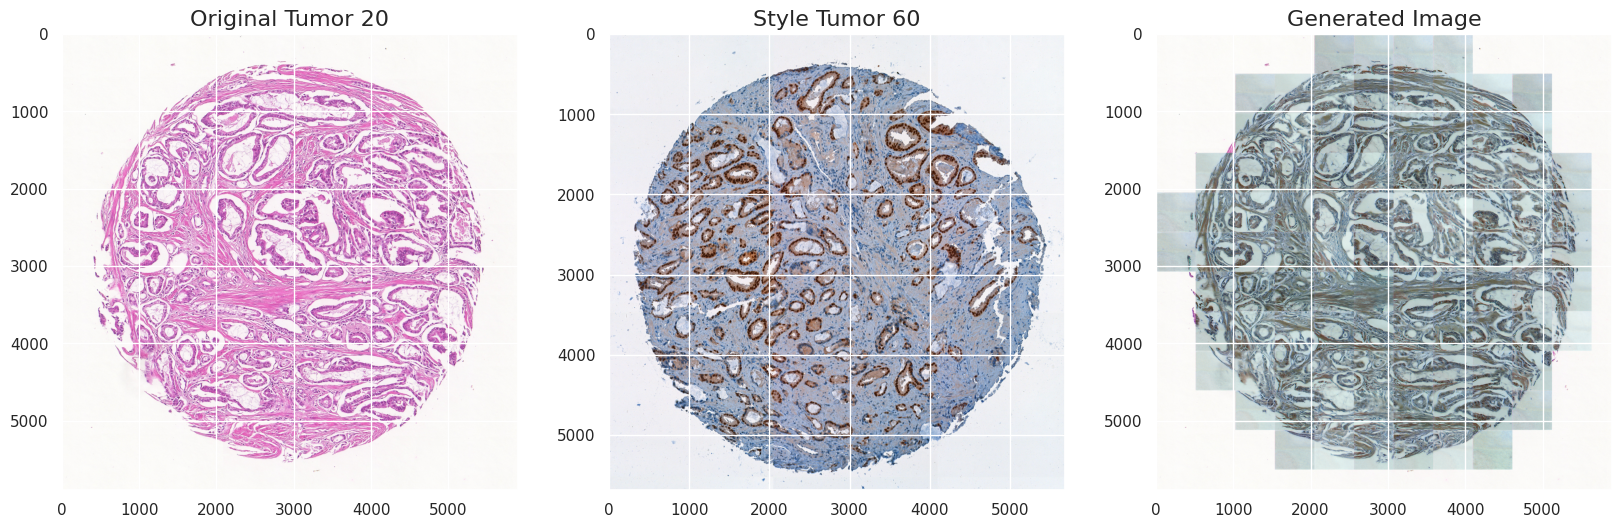

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(20, 15))  # 1x5 grid

# Plot original source image
axes[0].imshow(np.array(Image.open(tree_src.antibodies[idx_src])), cmap='viridis')
axes[0].set_title(f'Original Tumor {idx_src}', fontsize=16)

# Plot original destination image
axes[1].imshow(np.array(Image.open(tree_dst.antibodies[idx_dst])), cmap='viridis')
axes[1].set_title(f'Style Tumor {idx_dst}', fontsize=16)

# Plot decoded image
gen = []
with torch.no_grad():
    for i in range(len(patches_src)):
        # Assign idx_src and idx_dst to the patches
        src = patches_src[i]
        dst = patches_dst[torch.randint(0, len(patches_dst), (1,)).item()]

        # Convert to tensors
        src_tensor = Utilities.convert_numpy_to_tensor(src).to(device)
        dst_tensor = Utilities.convert_numpy_to_tensor(dst).to(device)

        timesteps = torch.randint(0, 1000, (batch_size,), device=device)  # Random timesteps

        # forward pass
        out = pipeline(src_tensor, dst_tensor, timesteps)
        gen.append(out.to(torch.uint8)[0].permute(1,2,0).detach().cpu().numpy())

generated = PatchesUtilities.replace_patches_in_image(
    original_image=np.array(Image.open(tree_src.antibodies[idx_src])),
    tissue_mask=PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_src.antibodies[idx_src]))),
    generated_patches=gen
)
axes[2].imshow(generated, cmap='viridis')
axes[2].set_title(f'Generated Image', fontsize=16)

In [12]:
pipeline.eval()
# for m in pipeline.modules():
#     if isinstance(m, nn.BatchNorm2d):
#         m.train()


OSGenPipeline(
  (encoder): VanillaEncoder(
    (encoder): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.01)
      )
    )
    (fc_mu): Linear(in_features=64, out_features=64, bias=True)
    (fc_var): Linear(in_features=64, out_features=64, bias=True)
    (noise_predictor): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (decoder_input): Linear(in_features=64, out_features=16384, bias=True)
    (decoder): Sequential(
      (0): Sequential(
        (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding

In [13]:
idx_src = 20 # torch.randint(0, len(tree_src.antibodies), (1,)).item()
patches_src = PatchesUtilities.get_image_patches_full(
    image = np.array(Image.open(tree_src.antibodies[idx_src])),
)

idx_dst = 60 # torch.randint(0, len(tree_dst.antibodies), (1,)).item()
patches_dst = PatchesUtilities.get_image_patches_full(
    image = np.array(Image.open(tree_dst.antibodies[idx_dst])),
)
print("idx_src: ", idx_src)
print("idx_dst: ", idx_dst)

idx_src:  20
idx_dst:  60


Text(0.5, 1.0, 'Generated Image')

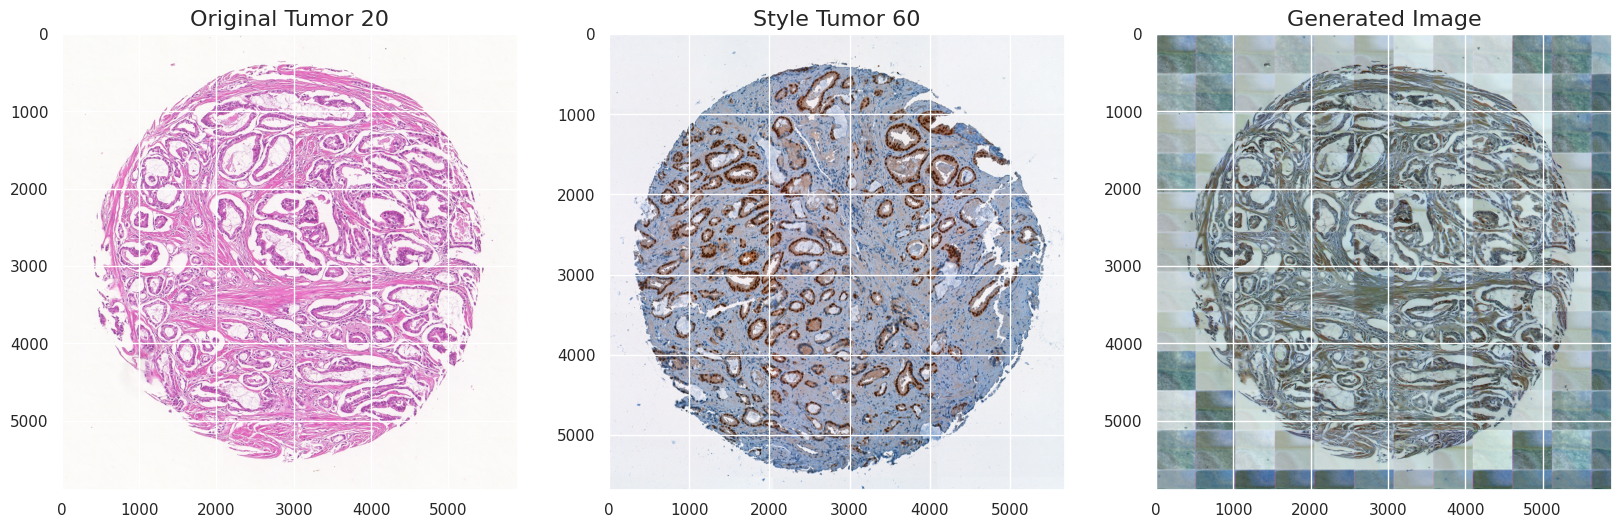

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(20, 15))  # 1x5 grid

# Plot original source image
axes[0].imshow(np.array(Image.open(tree_src.antibodies[idx_src])), cmap='viridis')
axes[0].set_title(f'Original Tumor {idx_src}', fontsize=16)

# Plot original destination image
axes[1].imshow(np.array(Image.open(tree_dst.antibodies[idx_dst])), cmap='viridis')
axes[1].set_title(f'Style Tumor {idx_dst}', fontsize=16)

# Plot decoded image
gen = []
with torch.no_grad():
    for i in range(len(patches_src)):
        # Assign idx_src and idx_dst to the patches
        src = patches_src[i]
        dst = patches_dst[torch.randint(0, len(patches_dst), (1,)).item()]

        # Convert to tensors
        src_tensor = Utilities.convert_numpy_to_tensor(src).to(device)
        dst_tensor = Utilities.convert_numpy_to_tensor(dst).to(device)

        timesteps = torch.randint(0, 1000, (batch_size,), device=device)  # Random timesteps

        # forward pass
        out = pipeline(src_tensor, dst_tensor, timesteps)
        gen.append(out.to(torch.uint8)[0].permute(1,2,0).detach().cpu().numpy())

generated = PatchesUtilities.replace_patches_in_image_full(
    original_image=np.array(Image.open(tree_src.antibodies[idx_src])),
    generated_patches=gen
)
axes[2].imshow(generated, cmap='viridis')
axes[2].set_title(f'Generated Image', fontsize=16)